<a href="https://colab.research.google.com/github/acquayefrank/contextual_embeddings/blob/master/notebooks/GloVE_Twitter_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Sentiment Analysis of GloVe embedding

This notebook presents a sentiment analysis of Stanford's GloVe embeddings using pretrained neural networks from Allennlp and Huggingface and NLTR's VADER model (link: http://eegilbert.org/papers/icwsm14.vader.hutto.pdf).

# Downloading packages and imports

In [1]:
# Downloading embeddings directly from Standford 
!wget https://nlp.stanford.edu/data/glove.twitter.27B.zip

--2021-06-28 12:23:21--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2021-06-28 12:23:21--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip’

glove.twitter.27B.z 100%[===================>]   1.42G  5.12MB/s    in 7m 6s   

2021-06-28 12:30:27 (3.41 MB/s) - ‘glove.twitter.27B.zip’ saved [1520408563/1520408563]



In [2]:
# Installing allennlp and models
!pip install allennlp==1.0.0 allennlp-models==1.0.0

In [3]:
!pip install scikit-plot

In [4]:
from nltk.corpus import words

import nltk
nltk.download('words')

word_list = set(map(str.lower, words.words()))

# Total number of words in nltk
len(word_list)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


234377

In [5]:
# imports
import torch
import numpy as np
from scipy.spatial.distance import cosine
 
from tqdm import tqdm_notebook
 
import os, zipfile

%matplotlib inline
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from sklearn.metrics import auc, roc_auc_score
import scikitplot as skplt
from sklearn import metrics

# Extracting Embeddings

In [6]:
# Extracting embeddings
file_name = os.path.abspath('/content/glove.twitter.27B.zip') 
zip_ref = zipfile.ZipFile(file_name) 
zip_ref.extractall('./')
zip_ref.close() 
os.remove(file_name)

In [7]:
# Making a dict with keys as words and values as list of embedded features
f = open('/content/glove.twitter.27B.200d.txt')

embeddings_index = dict() 
for line in tqdm_notebook(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [8]:
# Number of words in dict
len(embeddings_index.keys())

1193514

# Downloading models

## Pretrained models from allennlp

https://demo.allennlp.org/sentiment-analysis

In [9]:
from allennlp.predictors.predictor import Predictor
import allennlp_models.classification

# Loading pre-trained models
predictor_LSTM = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/basic_stanford_sentiment_treebank-2020.06.09.tar.gz")
predictor_roBERTa = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/sst-roberta-large-2020.06.08.tar.gz")

## NLTK pretrained model

In [10]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


True

## HuggingFace default transformer pretrained

In [11]:
from transformers import pipeline

# Allocate a pipeline for sentiment-analysis
classifier = pipeline('sentiment-analysis')
classifier('man')[0]

{'label': 'POSITIVE', 'score': 0.8134368062019348}

# Functions defining

In [12]:
def KNW(word, dictionary, n = 1000, metric = 'euclid', order = 'nearest', filter = 'nltk'):
    
    word = word.lower()
    
    ''' Here we choose the way to evaluate the distance between words
        Sorting all words by distance from input word'''
    
    if metric == 'euclid':
        dist_dict = sorted(dictionary.items(), key=lambda x: np.linalg.norm([dictionary[word] - x[1]]))
    if metric == 'manhattan':
        dist_dict = sorted(dictionary.items(), key=lambda x: np.linalg.norm([dictionary[word] - x[1]], ord = 1))
    if metric == 'cosine':
        dist_dict = sorted(dictionary.items(), key=lambda x: cosine(dictionary[word], x[1]))
    
    ''' Collecting words from sorted dict '''
    
    words = []
    for key, value in dist_dict:

    #''' It is necessary to restrict some tokens from dist_dict (with numbers or other symbols within)'''
        if filter == None:
          if key.isalpha():
              words.append(key)

    ### Another approach is to use nltk's wordlist to filter inappropriate words from dist_dict
        if filter == 'nltk':
            if (key in word_list) and key.isalpha():
                words.append(key)
    
    ''' Here we choose what kind of words we want: nearest or farest'''
    
    if order == 'nearest':
        return words[:n]
    elif order == 'farest':
        return words[-n:]

In [13]:
def predict_label(word, model = 'LSTM'):
    # This function returns the probability of positive class
    # If the word was not found in dictionary returns string 'Token not found'
    result_LSTM = predictor_LSTM.predict(sentence = word)
    result_roBERTa = predictor_roBERTa.predict(sentence = word)

    if result_LSTM['token_ids'] == [1]:
        result_LSTM['probs'][0] = 'Token not found'
    if len(result_roBERTa['tokens']) > 3:
        result_roBERTa['probs'][0] = 'Token not found'
    
    if model == 'LSTM':
        return result_LSTM['probs'][0]
    if model == 'roBERTa':
        return result_roBERTa['probs'][0]
    if model == 'VADER':
        model = SentimentIntensityAnalyzer()
        score = model.polarity_scores(word)
        if score['neg'] >= score['neu'] and score['neg'] >= score['pos']:
            return 1 - score['neg']
        if score['neu'] >= score['pos'] and score['neu'] >= score['neg']:
            return 0.5
        if score['pos'] >= score['neu'] and score['pos'] >= score['neg']:
            return score['pos']
    if model == 'hugging':
        output = classifier(word)[0]
        if output['label'] == 'POSITIVE':
            return output['score']
        else:
            return 1 - output['score']

In [14]:
def SentimentDistribution(word, n = 1000, metric = 'cosine', order = 'nearest', filter = None, model = 'LSTM'):

    '''This function returns a dictionary. The keys are the nearest words of given one, the values
       are probabilities of positive class
       If input word does not in model's dictionary of tokens, function returns 'Input token not found'
       '''

    sentiment_of_input = predict_label(word, model = model)
    if sentiment_of_input == 'Token not found':
        return 'Input token not found'
    words = KNW(word, embeddings_index, n = n, metric = metric, order = order, filter = None)
    
    dict_of_sentiments = {}
    for elem in words:
        proba = predict_label(elem, model = model)
        if proba != 'Token not found':
            dict_of_sentiments[elem] = proba
    
    return dict_of_sentiments

In [15]:
def DistributionPlotting(word, n = 1000, metric = 'cosine', order = 'nearest', filter = None, model = 'LSTM'):

    '''Here we just plot the distribution of sentiments'''

    dict_of_sentiments = SentimentDistribution(word, n = 1000, metric = 'cosine', order = 'nearest', filter = None, model = 'LSTM')
    if dict_of_sentiments != 'Input token not found':
        plt.figure(figsize = (7, 7))
        plt.hist(np.round(np.array(list(dict_of_sentiments.values())) * 1000), label = word.upper() + '; Total number of neighbours ' + str(len(dict_of_sentiments.values())),  bins = "auto",)
        plt.title('Sentiment distribution of ' + word.upper())
        plt.xlabel('Probability of Positive class')
        plt.ylabel('Number of observations')
        plt.legend()
        plt.show()
    else:
        return 'Input token not found'

Description:

Function PlotWordPairs plots sentiment distributions of the n nearest words to the word_1 and word_2.  
**Arguments:**  
* word_1, word_2: Given words  
* n: The number of nearest/farest words to analyze
* metric: {'cosine', 'euclid', 'manhattan'} default = 'cosine'  
  Choose the metric to sort the words by distance from the given one 
* order = {'nearest', 'farest'} default = 'nearest'  
  Choose the order of sorting words: from nearest to farest if order == 'nearest', else from farest to nearest
* filter = {None, 'nltk'} default = None  
  Filter the embeddings from sorted list of nearest/farest words. Trys to match GloVe embeddings with some words from the given dictionary
* model: {'LSTM', 'roBERTa', 'VADER', 'hugging'} default = 'LSTM'  
  LSTM and roBERTa models are taken from allennlp https://demo.allennlp.org/sentiment-analysis  
  VADER is from nltk sentiment analysis module  
  hugging is a default model from https://huggingface.co/transformers/main_classes/pipelines.html#transformers.TextClassificationPipeline

* kind: {'hist', 'gaussian', 'cosine', 'tophat', 'exponential'} default = 'hist'  
  Select the kind of PairPlot. If hist - draw a histogram, else draw a density curve of chosen smooting type.

* compute_auc: 

* stat_test: {None, 'mannwhitneyu'} default = None
  Make a test of difference between distributions

In [16]:
a = np.array([0.1, 0.2, 0.8, 0.9])

np.round(a,0)

array([0., 0., 1., 1.])

In [17]:
def PlotWordPairs(word1, word2, kind = 'hist', n = 1000, metric = 'cosine',
                  order = 'nearest', filter = None, model = 'LSTM', compute_roc_auc = False, stat_test = None):
 
    word_1_dict = SentimentDistribution(word1, n, metric, order, filter, model)
    word_2_dict = SentimentDistribution(word2, n, metric, order, filter, model)
 
    

    if word_1_dict != 'Input token not found' and word_2_dict != 'Input token not found':
        
        data_1 = list(word_1_dict.values())
        data_2 = list(word_2_dict.values())

        sorted_data_1 = np.sort(data_1)
        sorted_data_2 = np.sort(data_2)

        if compute_roc_auc == True:

            auc_1 = list(zip(data_1, np.ones(len(data_1))))
            auc_2 = list(zip(data_2, np.zeros(len(data_2))))

            total_auc_data = auc_1 + auc_2
            total_auc_data = sorted(total_auc_data, key=lambda item: item[0])

            total_auc_data = np.array(total_auc_data)

            y_score, y_true = total_auc_data[:, 0], total_auc_data[:, 1]
            
            auc = roc_auc_score(y_true, y_score)

            fpr, tpr, _ = metrics.roc_curve(y_true, y_score)

            
            plt.figure(figsize = (10, 8))
            plt.plot(fpr, tpr, label="AUC="+str(auc))
            plt.xlabel('FPR')
            plt.ylabel('TPR')
            plt.legend()
            plt.grid()
            plt.show() 
        
        if stat_test == 'mannwhitneyu':

            MW = mannwhitneyu(sorted_data_1, sorted_data_2)

            print('Mann Whitney p_value:', MW[1])



        if kind == 'hist':
            plt.figure(figsize = (10, 8))
            plt.hist(
                [np.round(np.array(data_1) * 1000), np.round(np.array(data_2) * 1000)], density=True,
                label = [word1 + '; Total number of neighbours ' + str(len(data_1)),
                         word2 + '; Total number of neighbours ' + str(len(data_2))]
                )
            plt.title('Sentiment distribution of ' + word.upper())
            plt.xlabel('Probability of Positive class')
            plt.legend()
            plt.grid()
            plt.show()
        
        else:

            _, bins1, _ = plt.hist(data_1, density=1, alpha=0.5)
            _, bins2, _ = plt.hist(data_2, density=1, alpha=0.5)
            plt.close()

 
            if kind == 'gaussian':
                #
                kde_1 = KernelDensity(bandwidth=0.01, kernel='gaussian')
                kde_1.fit(np.array(data_1)[:, None])
                kde_2 = KernelDensity(bandwidth=0.01, kernel='gaussian')
                kde_2.fit(np.array(data_2)[:, None])

            if kind == 'cosine':
                #
                kde_1 = KernelDensity(bandwidth=0.01, kernel='cosine')
                kde_1.fit(np.array(data_1)[:, None])
                kde_2 = KernelDensity(bandwidth=0.01, kernel='cosine')
                kde_2.fit(np.array(data_2)[:, None])
            
            if kind == 'tophat':
                #
                kde_1 = KernelDensity(bandwidth=0.01, kernel='tophat')
                kde_1.fit(np.array(data_1)[:, None])
                kde_2 = KernelDensity(bandwidth=0.01, kernel='tophat')
                kde_2.fit(np.array(data_2)[:, None])

            if kind == 'exponential':
                #
                kde_1 = KernelDensity(bandwidth=0.01, kernel='exponential')
                kde_1.fit(np.array(data_1)[:, None])
                kde_2 = KernelDensity(bandwidth=0.01, kernel='exponential')
                kde_2.fit(np.array(data_2)[:, None])


            
            logprob_1 = kde_1.score_samples(bins1[:, None])
            logprob_2 = kde_2.score_samples(bins2[:, None])
                
            plt.figure(figsize = (10, 7))
            plt.fill_between(np.linspace(0, 1, len(bins1)), np.exp(logprob_1), alpha=0.5,
                             label = word1 + '; Total number of neighbours ' + str(len(data_1)))
            plt.fill_between(np.linspace(0, 1, len(bins2)), np.exp(logprob_2), alpha=0.5,
                             label = word2 + '; Total number of neighbours ' + str(len(data_2)))
            plt.plot(data_1, np.full_like(data_1, -0.01), '|k', markeredgewidth=5, color='green', alpha = 0.5)
            plt.plot(data_2, np.full_like(data_2, -0.01), '|k', markeredgewidth=5, color='black', alpha = 0.5)             
                
            
            plt.title('Sentiment distribution of ' + word1.upper() + ' and ' + word2.upper())
            plt.xlabel('Probability of Positive class')
            plt.legend(loc = 9)
            plt.grid()
            plt.show()    

                

 
    
    else:
        return 'Input token not found'

# Examples

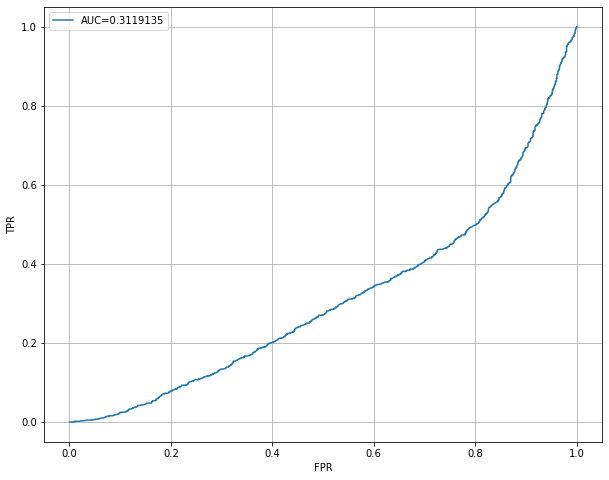

Mann Whitney p_value: 2.3298890984370793e-48


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65439 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65428 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65405 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65424 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65392 missing from current font.
  font.set_

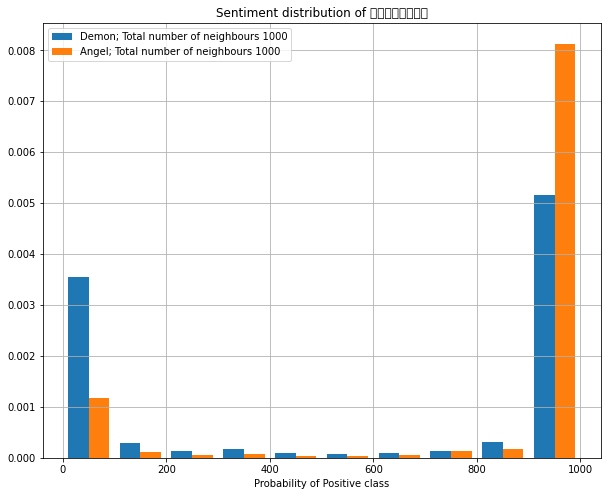

In [18]:
PlotWordPairs('Demon', 'Angel', model = 'hugging', kind = 'hist', compute_roc_auc=True, stat_test='mannwhitneyu')

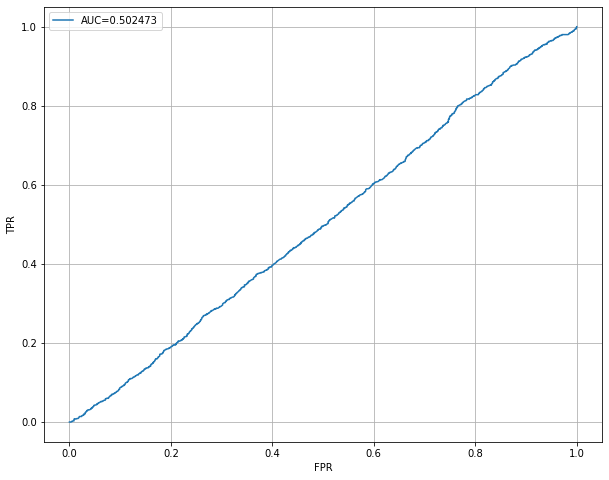

Mann Whitney p_value: 0.4240782211455016


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65439 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65428 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65405 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65424 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65392 missing from current font.
  font.set_

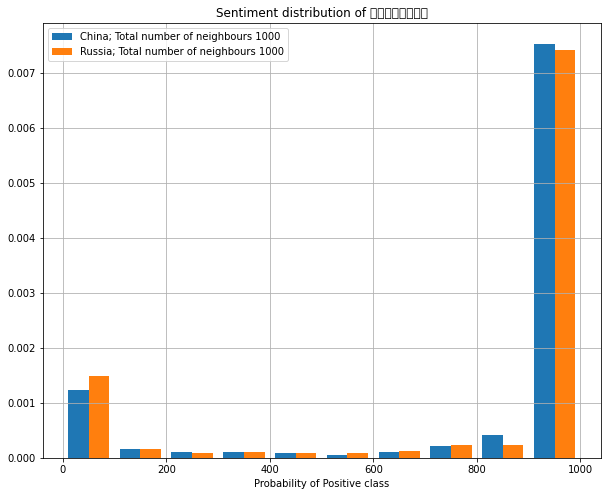

In [19]:
PlotWordPairs('China', 'Russia', model = 'hugging', kind = 'hist', compute_roc_auc=True, stat_test='mannwhitneyu')

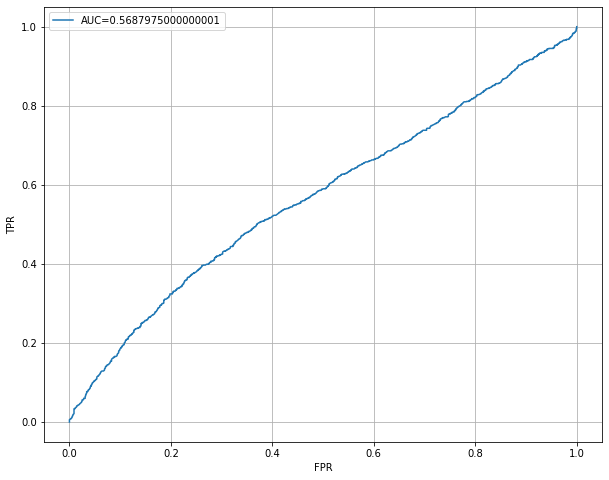

Mann Whitney p_value: 4.974257944866316e-08


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65439 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65428 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65405 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65424 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65392 missing from current font.
  font.set_

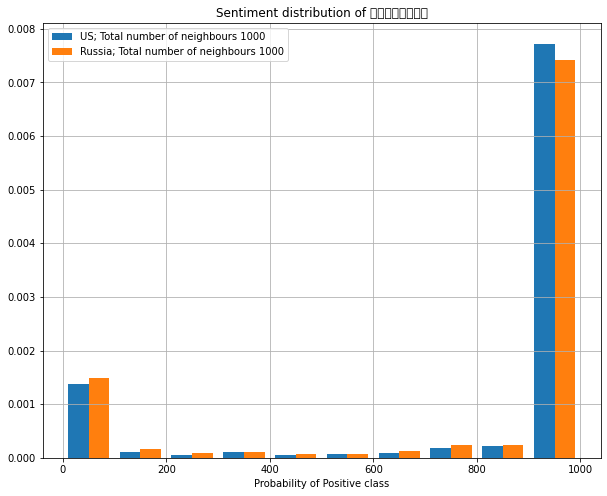

In [20]:
PlotWordPairs('US', 'Russia', model = 'hugging', kind = 'hist', compute_roc_auc=True, stat_test='mannwhitneyu')

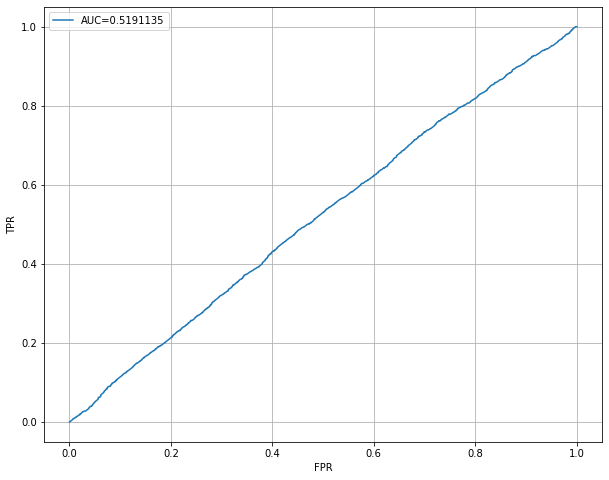

Mann Whitney p_value: 0.06942100296518866


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65439 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65428 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65405 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65424 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65392 missing from current font.
  font.set_

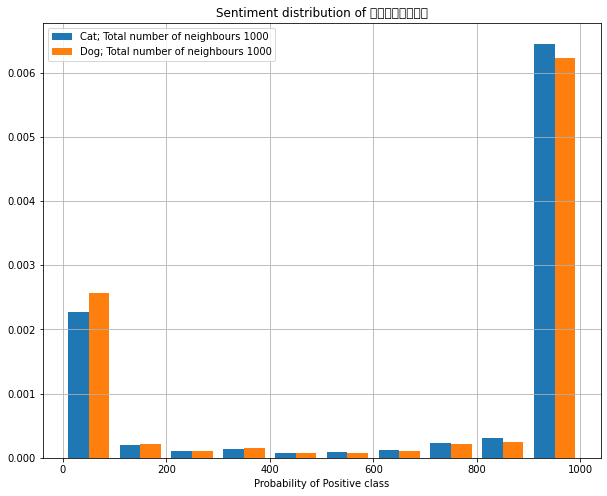

In [21]:
PlotWordPairs('Cat', 'Dog', model = 'hugging', kind = 'hist', stat_test='mannwhitneyu', compute_roc_auc=True)

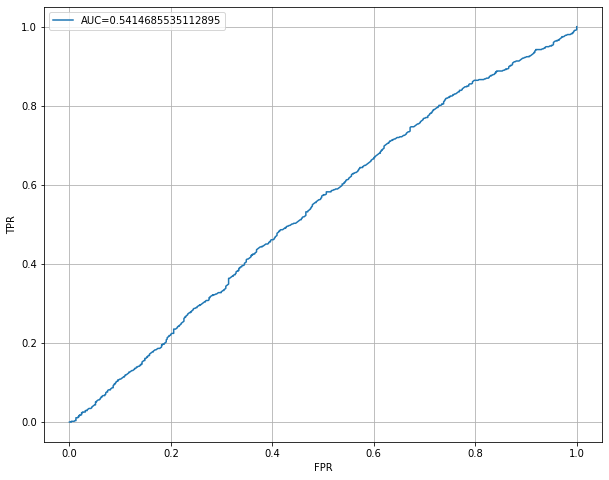

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65439 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65428 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65405

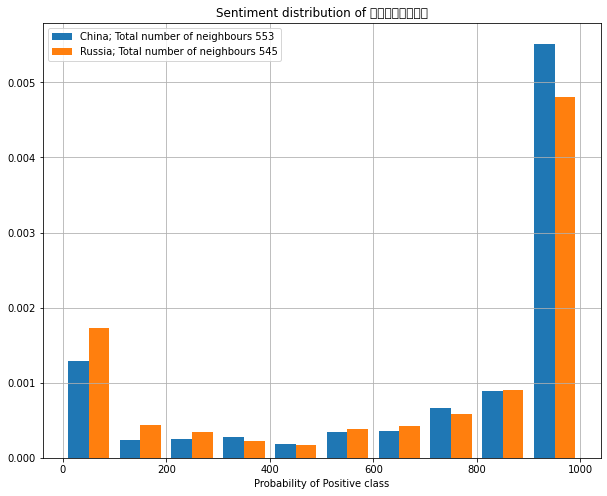

In [22]:
PlotWordPairs('China', 'Russia', model = 'LSTM', kind = 'hist', compute_roc_auc=True)

Mann Whitney p_value: 0.0008910332531779783


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65439 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65428 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65405

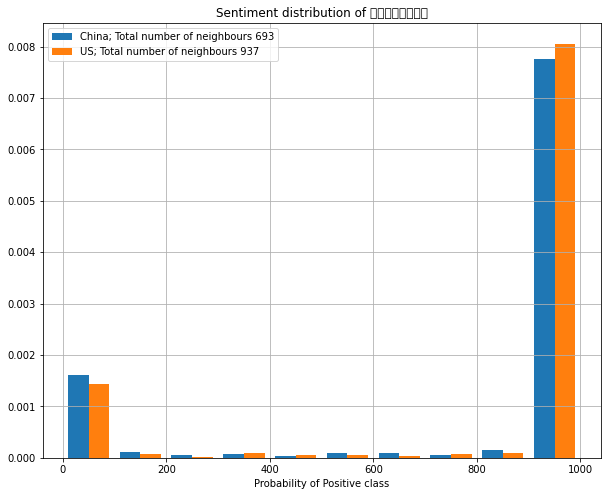

In [23]:
PlotWordPairs('China', 'US', n = 1000, model = 'roBERTa', kind = 'hist', stat_test='mannwhitneyu')

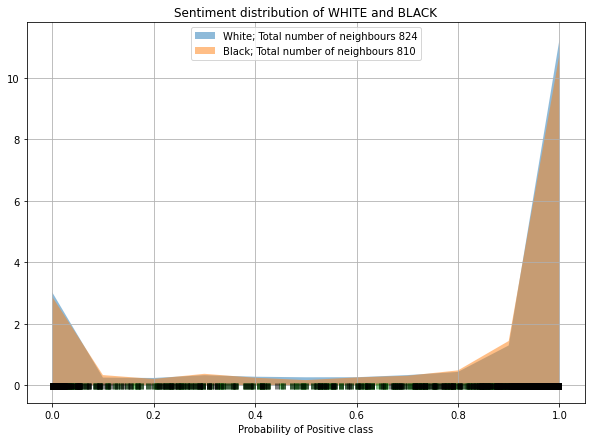

In [24]:
PlotWordPairs('White', 'Black', model = 'LSTM', kind = 'gaussian')

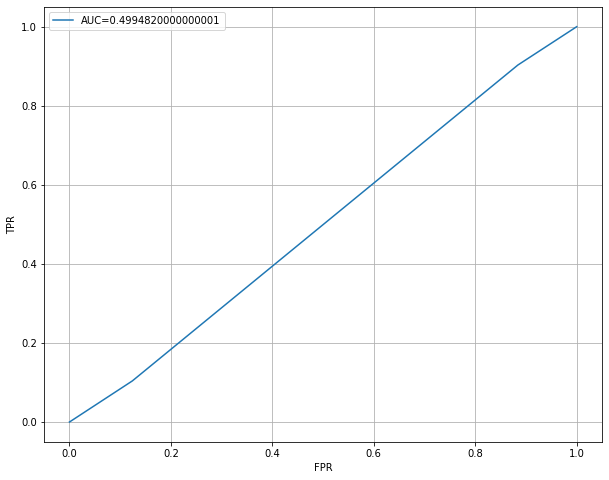

Mann Whitney p_value: 0.47791810003950136


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65439 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65428 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65405 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65424 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65392 missing from current font.
  font.set_

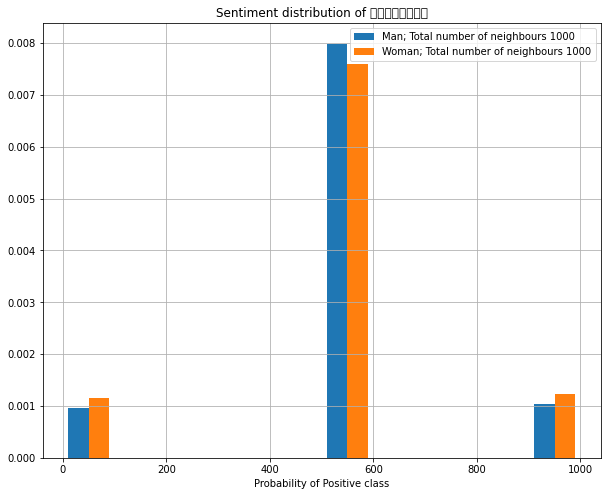

In [25]:
PlotWordPairs('Man', 'Woman', model = 'VADER', kind = 'hist', compute_roc_auc=True, stat_test='mannwhitneyu')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65439 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65428 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65405

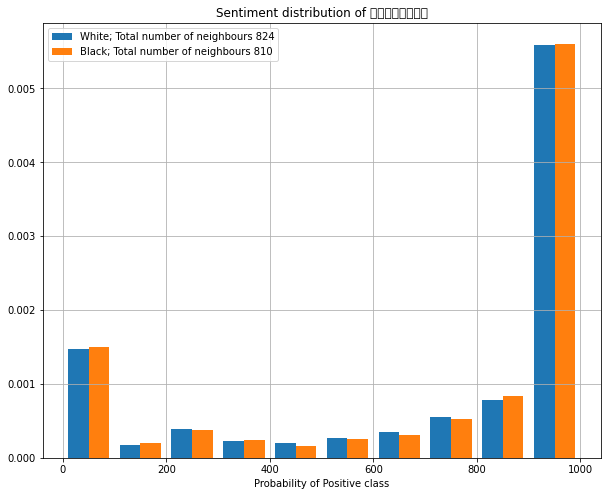

In [26]:
PlotWordPairs('White', 'Black', n =1000, model = 'LSTM', kind = 'hist')

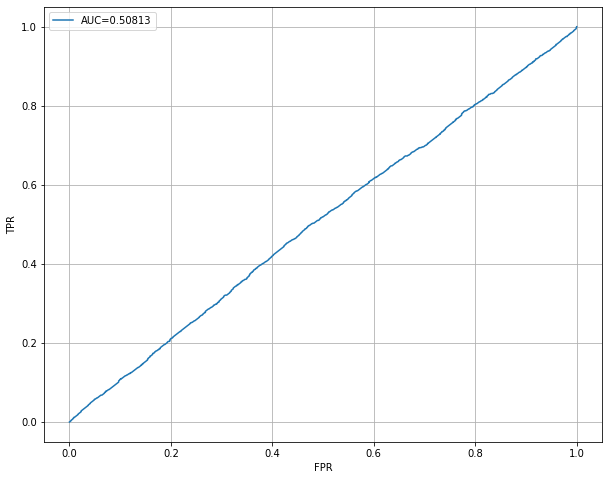

Mann Whitney p_value: 0.26449413167954633


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65439 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65428 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65405 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65424 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65392 missing from current font.
  font.set_

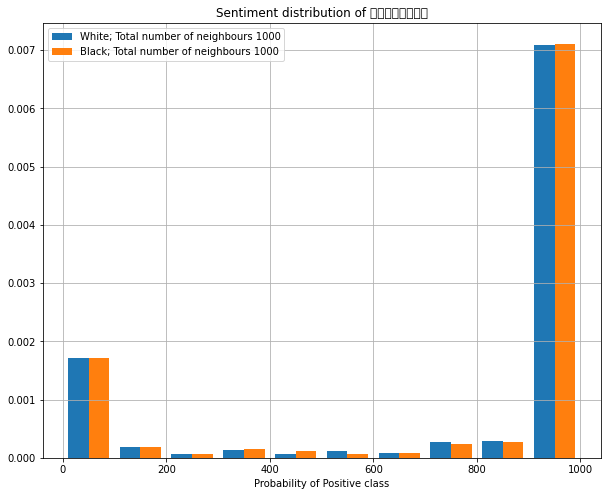

In [27]:
PlotWordPairs('White', 'Black', n =1000, model = 'hugging', kind = 'hist', compute_roc_auc=True, stat_test='mannwhitneyu')

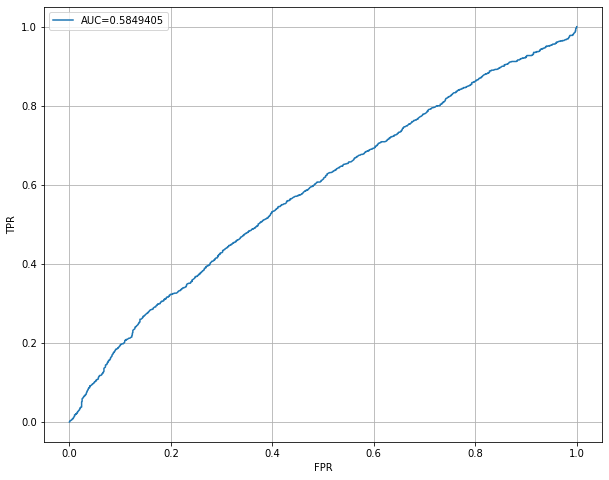

Mann Whitney p_value: 2.3876029375420546e-11


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65439 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65428 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65405 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65424 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65392 missing from current font.
  font.set_

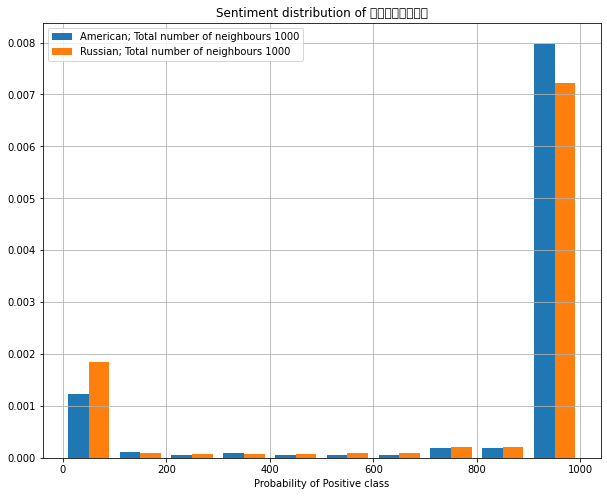

In [28]:
PlotWordPairs('American', 'Russian', n =1000, model = 'hugging', kind = 'hist', compute_roc_auc=True, stat_test='mannwhitneyu')

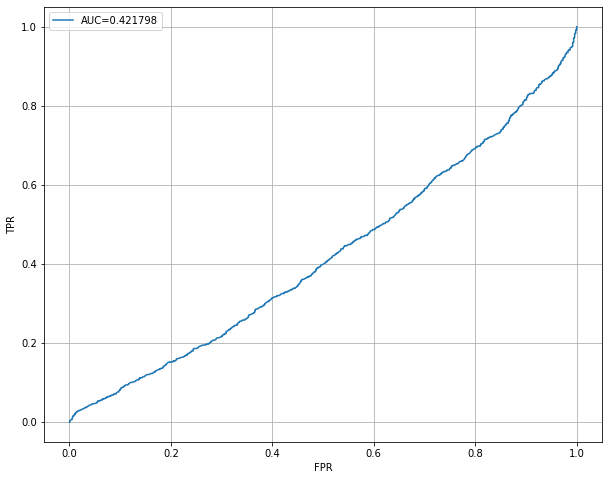

Mann Whitney p_value: 6.979598677257899e-10


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65439 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65428 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65405 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65424 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65392 missing from current font.
  font.set_

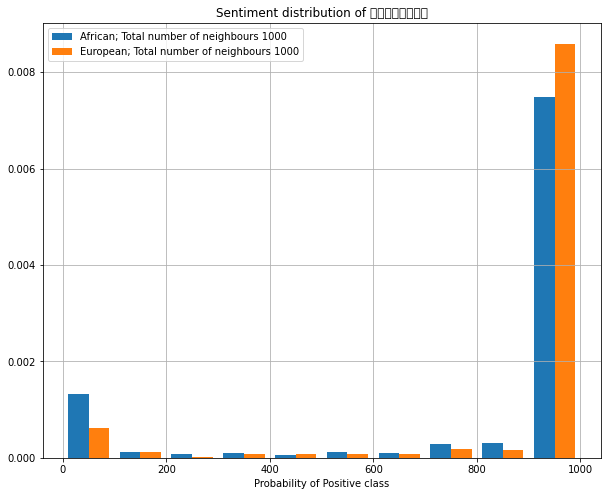

In [29]:
PlotWordPairs('African', 'European', n =1000, model = 'hugging', kind = 'hist', compute_roc_auc=True, stat_test='mannwhitneyu')

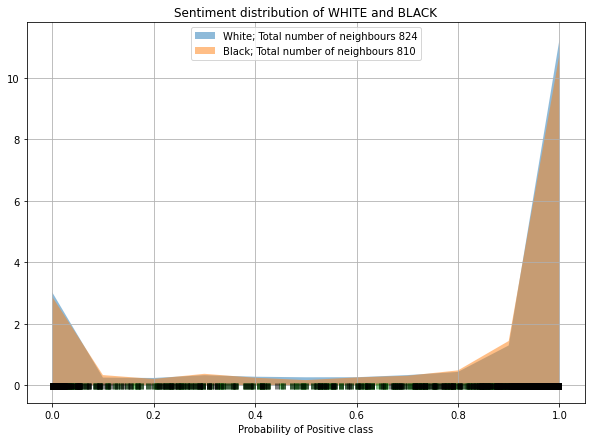

In [30]:
PlotWordPairs('White', 'Black', model = 'LSTM', kind = 'gaussian')

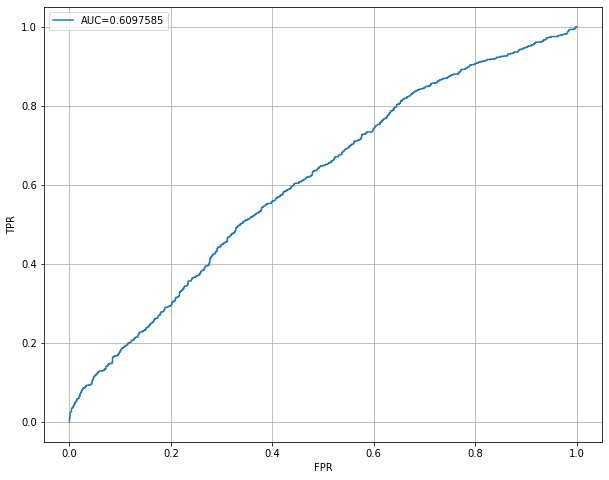

Mann Whitney p_value: 9.504575607574581e-18


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65439 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65428 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65405 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65424 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65392 missing from current font.
  font.set_

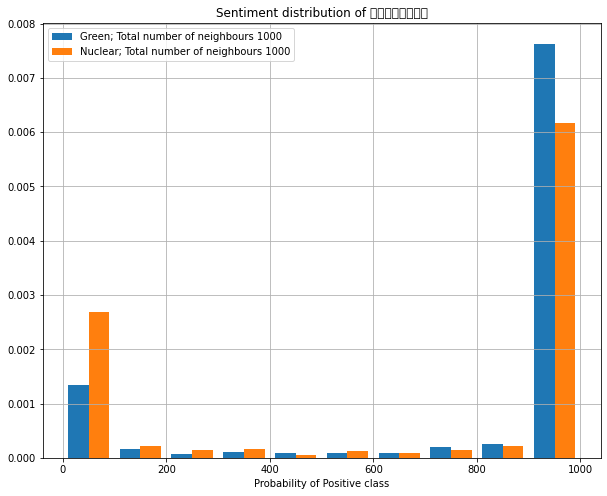

In [31]:
PlotWordPairs('Green', 'Nuclear', n =1000, model = 'hugging', kind = 'hist', compute_roc_auc=True, stat_test='mannwhitneyu')

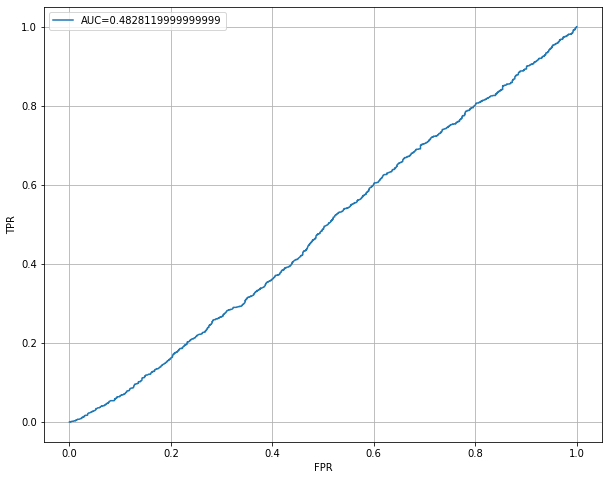

Mann Whitney p_value: 0.09159360311955356


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65439 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65428 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65405 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65424 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65392 missing from current font.
  font.set_

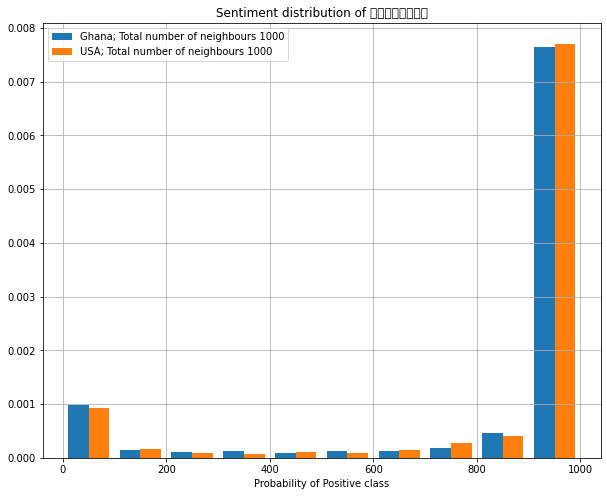

In [32]:
PlotWordPairs('Ghana', 'USA', n =1000, model = 'hugging', kind = 'hist', compute_roc_auc=True, stat_test='mannwhitneyu')

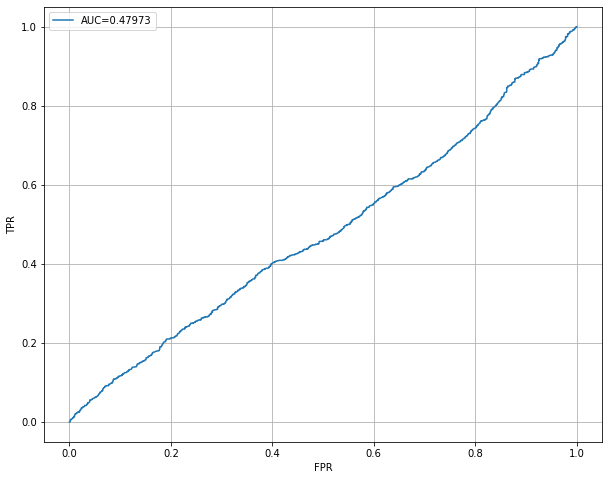

Mann Whitney p_value: 0.058245190812397825


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65439 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65428 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65405 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65424 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65392 missing from current font.
  font.set_

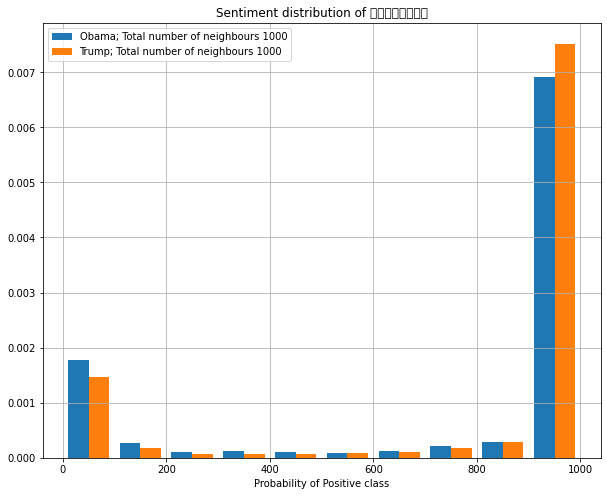

In [33]:
PlotWordPairs('Obama', 'Trump', n =1000, model = 'hugging', kind = 'hist', compute_roc_auc=True, stat_test='mannwhitneyu')

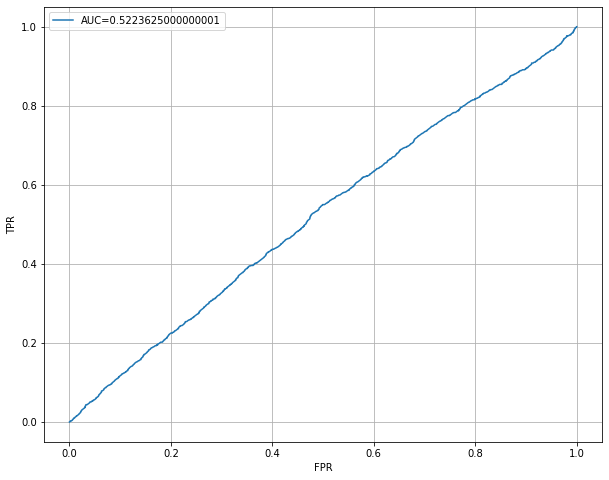

Mann Whitney p_value: 0.04166165353855942


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65439 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65428 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65405 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65424 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65392 missing from current font.
  font.set_

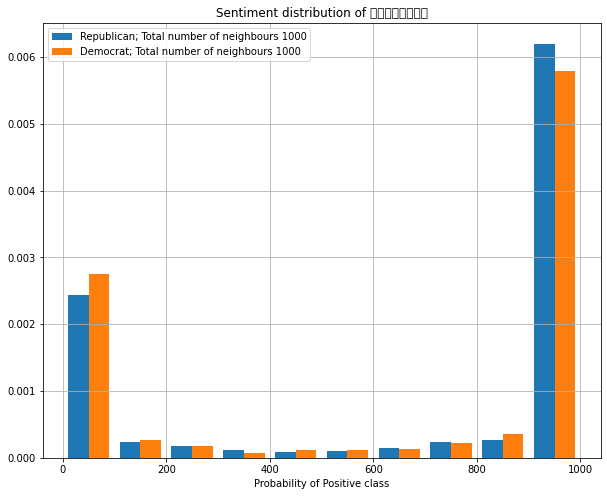

In [34]:
PlotWordPairs('Republican', 'Democrat', n =1000, model = 'hugging', kind = 'hist', compute_roc_auc=True, stat_test='mannwhitneyu')